## Recursion formulae for $\mathbb{p}_2$

In this notebook we validate our recursion formulae for the integral $\mathbb{p}_2$.

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [3]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from mpmath import ellipf, ellipe, ellippi
from tqdm.notebook import tqdm
import warnings

warnings.simplefilter("ignore")

Here is the definition of the $\mathbb{p}_2$ integral, which we compute numerically:

In [232]:
def p2exact(bo, ro, phi):
    """
    The function p2 evaluated by direct numerical integration.
    
    """
    res = 0
    for i in range(0, len(phi), 2):
        def func(phi):
            sinphi = np.sin(phi)
            z = np.sqrt(1 - ro ** 2 - bo ** 2 - 2 * bo * ro * sinphi)
            return (1.0 - z ** 3) / (1.0 - z ** 2) * (ro + bo * sinphi) * ro / 3.0
        res += quad(func, phi[i], phi[i + 1], epsabs=1e-12, epsrel=1e-12,)[0]
    return res

And here is our analytic expression, computed from elliptic integrals:

In [265]:
@np.vectorize
def F(phi, k2):
    """Incomplete elliptic integral of the first kind."""
    return float(ellipf(phi, k2).real)


@np.vectorize
def E(phi, k2):
    """Incomplete elliptic integral of the second kind."""
    return float(ellipe(phi, k2).real)


@np.vectorize
def Pi(n, phi, k2):
    """Incomplete elliptic integral of the third kind."""
    return float(ellippi(n, phi, k2).real)


def P(n, phi, k2):
    return (6.0 / n) * (F(phi, k2) - Pi(n, phi, k2))


def Delta(x):
    """The sum over the pairwise differences of an array."""
    return sum(-np.array(x)[::2] + np.array(x)[1::2])


def delta(bo, ro, alpha):
    delta = np.zeros_like(alpha)
    for i in range(len(alpha)):
        if alpha[i] > 3 * np.pi / 2:
            if bo - ro > 0:
                delta[i] = -2 * np.pi
            elif bo - ro < 0:
                delta[i] = 2 * np.pi
    return delta


def p2(bo, ro, phi):
    """
    The p2 term, computed analytically.
    
    """
    # The modified limits of integration
    alpha = phi / 2 + np.pi / 4

    # Helper vars
    k2 = (1 - ro ** 2 - bo ** 2 + 2 * bo * ro) / (4 * bo * ro)
    n = -4 * bo * ro / (ro - bo) ** 2
    fac = np.sqrt(1 - (bo - ro) ** 2)
    term = np.sqrt(1 - (bo - ro) ** 2 - 4 * bo * ro * np.sin(alpha) ** 2)
    
    # Coefficients
    c0 = Delta(
        -np.arctan2(-(bo - ro) * np.cos(alpha), (bo + ro) * np.sin(alpha))
        + alpha
        - (4.0 / 3.0)
        * bo * ro
        * np.sin(alpha)
        * np.cos(alpha)
        * term
        + delta(bo, ro, alpha)
    )
    c1 = (1 + bo ** 4 - bo ** 2 * (5 + 2 * ro ** 2) + ro ** 4 + ro ** 2) / (3 * fac)
    c2 = (bo ** 2 + 7 * ro ** 2 - 4) / 3 * fac
    c3 = (bo + ro) / (bo - ro) / fac
    
    return (
        c0
        + c1 * Delta(F(alpha, 1 / k2))
        + c2 * Delta(E(alpha, 1 / k2))
        + c3 * Delta(Pi(n, alpha, 1 / k2))
    ) / 3.0

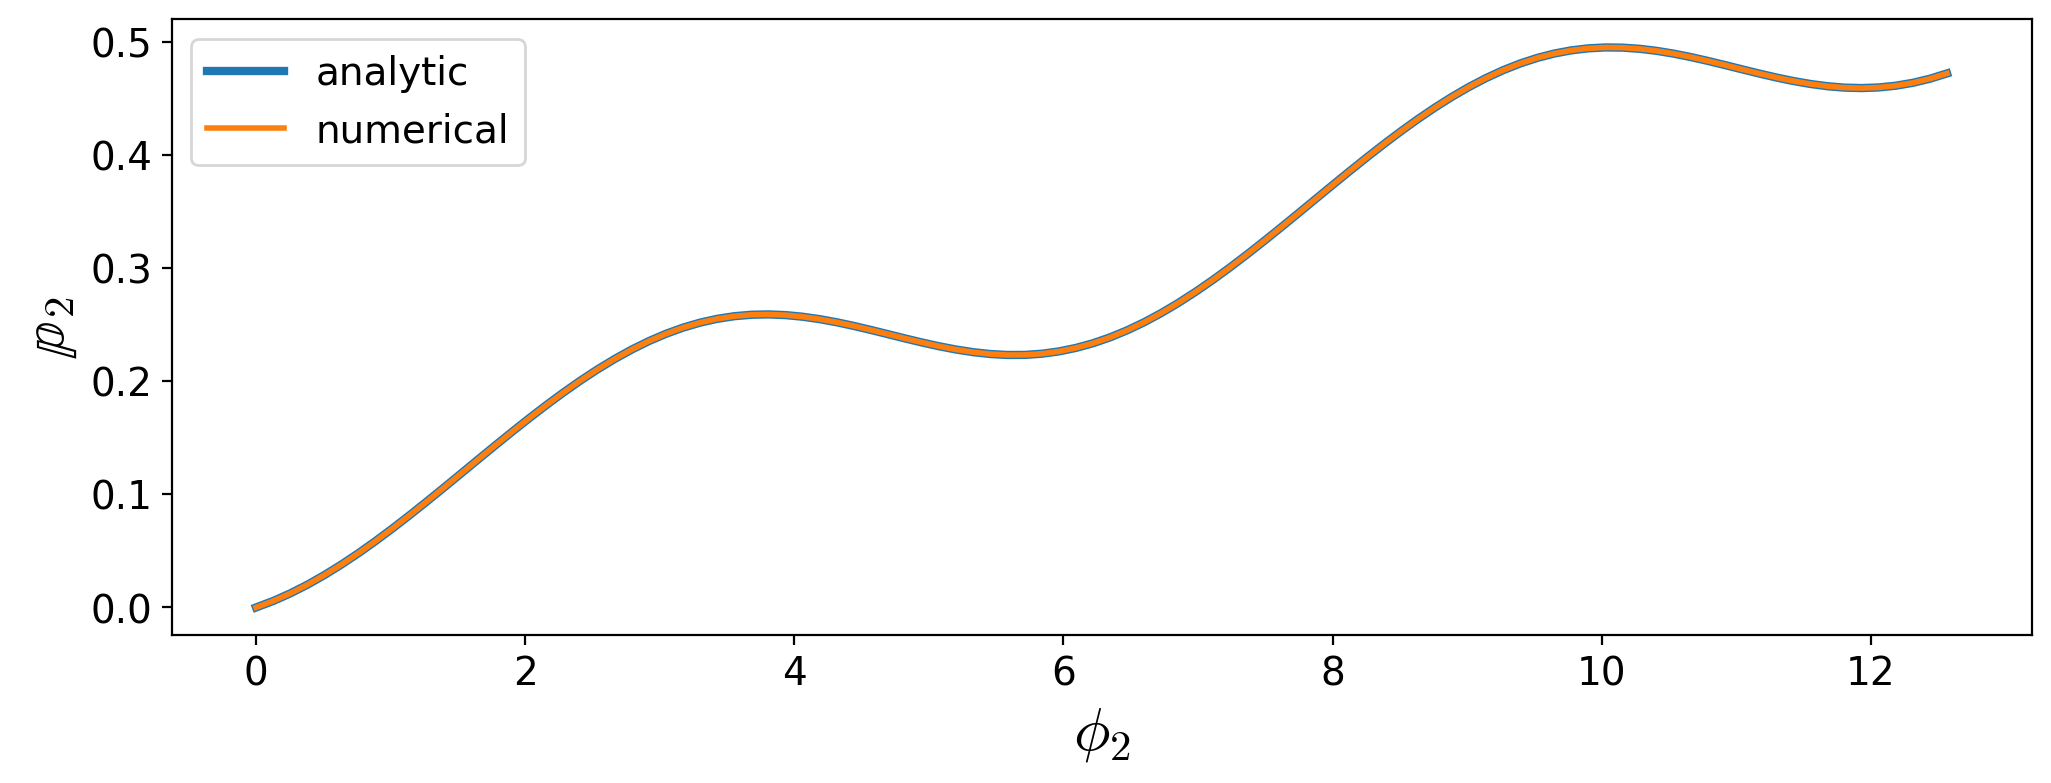

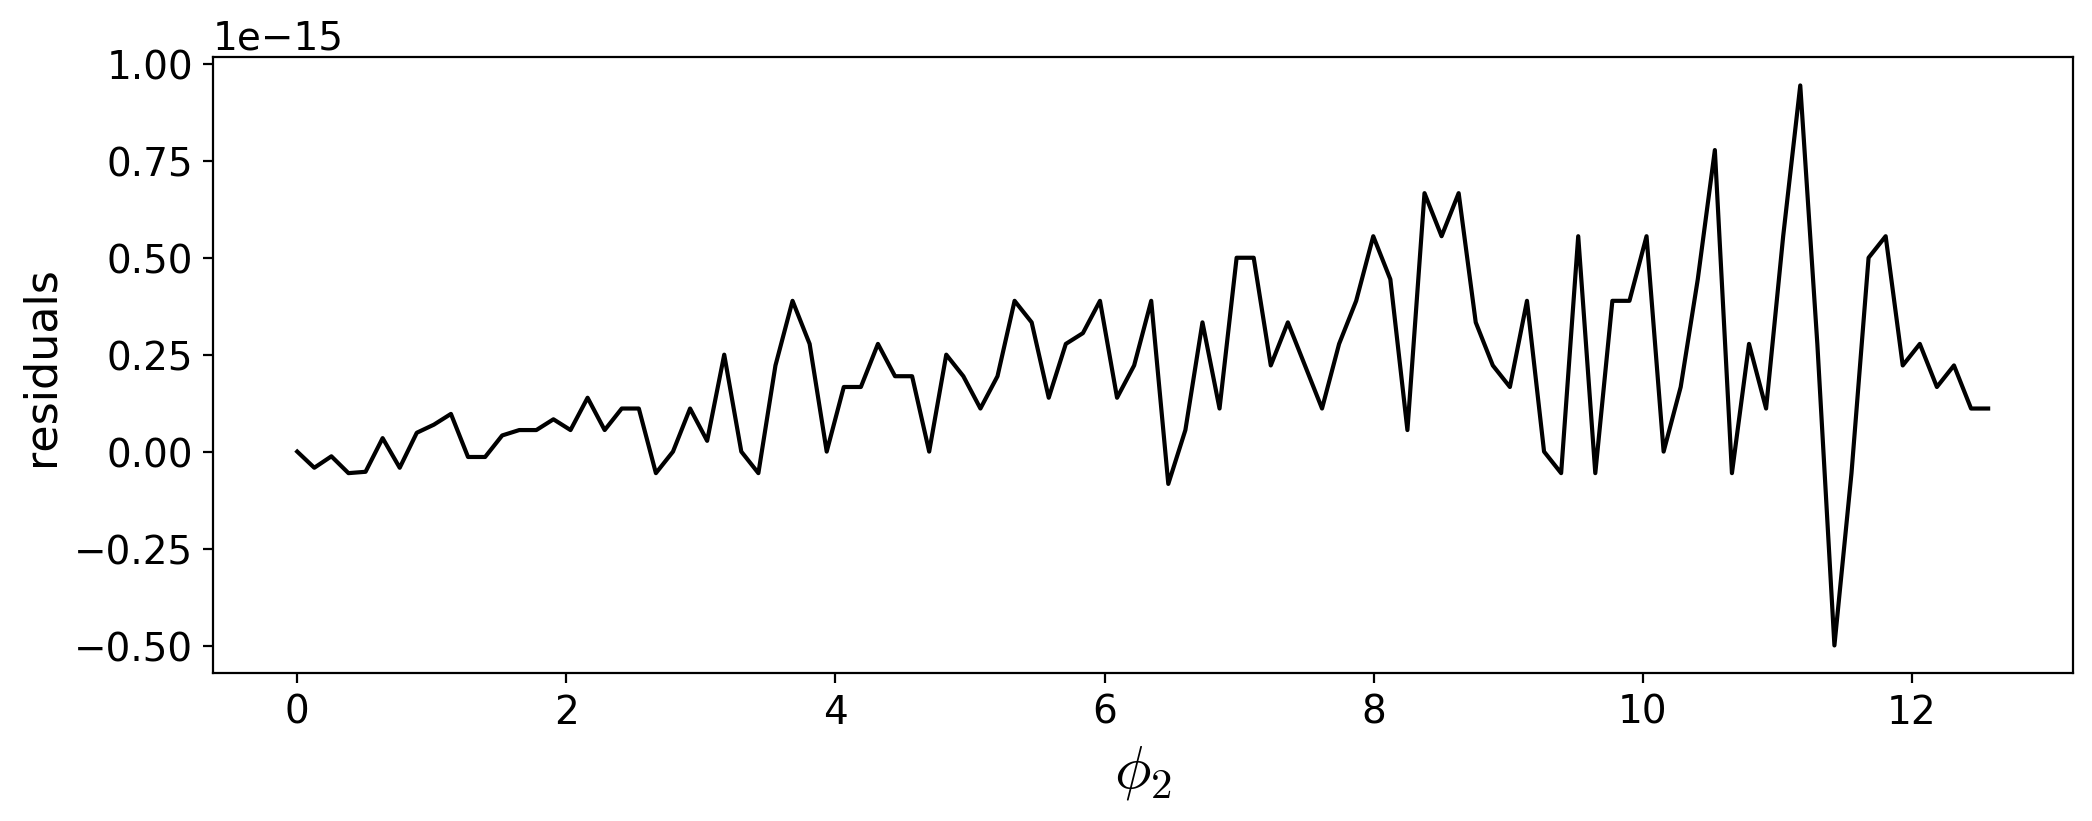

In [269]:
bo = 0.5
ro = 0.3
phi0 = 0
phi1 = np.linspace(0, 4 * np.pi, 100)

f1 = np.array([p2(bo, ro, np.array([phi0, phi1_i])) for phi1_i in phi1])
f2 = np.array([p2exact(bo, ro, np.array([phi0, phi1_i])) for phi1_i in phi1])

plt.plot(phi1, f1, lw=3, label="analytic")
plt.plot(phi1, f2, lw=2, label="numerical")
plt.xlabel(r"$\phi_2$", fontsize=22)
plt.ylabel(r"$\mathbb{p}_2$", fontsize=22)
plt.legend()

plt.figure()
plt.plot(phi1, (f1 - f2), "k-")
plt.xlabel(r"$\phi_2$", fontsize=22)
plt.ylabel(r"residuals", fontsize=16);